# PBMC multiome workflow snapatac2

# Annotating cell clusters by integrating single-cell RNA-seq data

In [1]:
import snapatac2 as snap
import scanpy as sc
import numpy as np
import scvi
snap.__version__
from scanpy import read_h5ad

2023-04-03 10:58:40 - INFO - Created a temporary directory at /tmp/tmp6teacjr6
2023-04-03 10:58:40 - INFO - Writing /tmp/tmp6teacjr6/_remote_module_non_scriptable.py
2023-04-03 10:58:41 - INFO - Global seed set to 0
/vol/mbconda/imarais/miniconda3/envs/snapatac2/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/vol/mbconda/imarais/miniconda3/envs/snapatac2/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


## Preparing data

In [2]:
rna_PBMC= sc.read("rna_PBMC.h5ad")

# Notes: the default assays for atac_PBMC and rna_PBMC are "peaks" and "counts" respectively

# Nessesary pre-processing from converted Seurat object
rna_PBMC.obs['predicted.id'] = rna_PBMC.obs['predicted.id'].str.replace(' ', '-')

reference = rna_PBMC
reference

AnnData object with n_obs × n_vars = 11331 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'predicted.id', 'prediction.score.Mono', 'prediction.score.CD4.T', 'prediction.score.CD8.T', 'prediction.score.NK', 'prediction.score.B', 'prediction.score.other.T', 'prediction.score.other', 'prediction.score.DC', 'prediction.score.max', 'SCT.weight', 'prediction.score.CD14.Mono', 'prediction.score.CD4.TCM', 'prediction.score.CD8.Naive', 'prediction.score.CD8.TEM', 'prediction.score.CD16.Mono', 'prediction.score.B.intermediate', 'prediction.score.CD4.Naive', 'prediction.score.CD4.CTL', 'prediction.score.B.naive', 'prediction.score.MAIT', 'prediction.score.gdT', 'prediction.score.CD8.TCM', 'prediction.score.dnT', 'prediction.score.B.memory', 'prediction.score.Doublet', 'prediction.score.pDC', 'prediction.score.CD8.Proliferating', 'prediction.

In [4]:
# check the genes of the reference
reference.X

<11331x36601 sparse matrix of type '<class 'numpy.float64'>'
	with 22719828 stored elements in Compressed Sparse Row format>

In [3]:
#ATAC seq 
query = sc.read("gene_matrix.h5ad")
query

AnnData object with n_obs × n_vars = 458 × 35955
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_score', 'is_doublet', 'leiden'
    var: 'n_cells'
    uns: 'leiden_colors', 'log1p'
    obsm: 'X_umap'

In [9]:
# # Convert to gene matrix and check the number; should not be over 70000:
# # Only make the matrix if you don't have it yet
# query = snap.pp.make_gene_matrix(query, snap.genome.hg38)
# query

In [4]:
data = reference.concatenate(query, batch_categories=["reference", "query"])
data.obs['cell_type'] = data.obs['predicted.id'] # predicted ID is the correct labeling
data

/vol/mbconda/imarais/miniconda3/envs/snapatac2/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 11789 × 20443
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'predicted.id', 'prediction.score.Mono', 'prediction.score.CD4.T', 'prediction.score.CD8.T', 'prediction.score.NK', 'prediction.score.B', 'prediction.score.other.T', 'prediction.score.other', 'prediction.score.DC', 'prediction.score.max', 'SCT.weight', 'prediction.score.CD14.Mono', 'prediction.score.CD4.TCM', 'prediction.score.CD8.Naive', 'prediction.score.CD8.TEM', 'prediction.score.CD16.Mono', 'prediction.score.B.intermediate', 'prediction.score.CD4.Naive', 'prediction.score.CD4.CTL', 'prediction.score.B.naive', 'prediction.score.MAIT', 'prediction.score.gdT', 'prediction.score.CD8.TCM', 'prediction.score.dnT', 'prediction.score.B.memory', 'prediction.score.Doublet', 'prediction.score.pDC', 'prediction.score.CD8.Proliferating', 'prediction.

In [7]:
# Check reference and query cells + cell_type column
data.obs

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS.enrichment,TSS.percentile,nCount_SCT,...,prediction.score.ILC,tsse,n_fragment,frac_dup,frac_mito,doublet_score,is_doublet,leiden,batch,cell_type
AAACAGCCAAGGAATC-1-reference,0.0,8380.0,3308.0,55582.0,13878.0,0.903306,0.42,5.130258,0.90,4666.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,reference,CD4-Naive
AAACAGCCAATCCCTT-1-reference,0.0,3771.0,1896.0,20495.0,7253.0,0.884361,0.37,4.488912,0.49,3777.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,reference,CD4-TCM
AAACAGCCAATGCGCT-1-reference,0.0,6876.0,2904.0,16674.0,6528.0,0.969553,0.61,4.325205,0.35,4653.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,reference,CD4-Naive
AAACAGCCACACTAAT-1-reference,0.0,1733.0,846.0,2007.0,906.0,0.953216,0.56,4.523255,0.52,3342.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,reference,CD8-Naive
AAACAGCCACCAACCG-1-reference,0.0,5415.0,2282.0,7658.0,3323.0,0.916549,0.46,3.825122,0.07,4461.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,reference,CD8-Naive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453-query,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,34.996853,25301.0,0.725171,0.0,0.121951,False,2,query,NaN
454-query,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30.077369,5295.0,0.628238,0.0,0.121951,False,0,query,NaN
455-query,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,21.811976,28547.0,0.690986,0.0,0.250000,False,0,query,NaN
456-query,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,29.126794,7000.0,0.729636,0.0,0.068966,False,0,query,NaN


In [5]:
# You can already test if this works and scvi-tools is installed correctly with the cells below
data.layers["counts"] = data.X.copy()
sc.pp.filter_genes(data, min_cells=5)
sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)
sc.pp.highly_variable_genes(
    data,
    n_top_genes = 5000,
    flavor="seurat_v3",
    layer="counts",
    batch_key="batch",
    subset=True
)

/vol/mbconda/imarais/miniconda3/envs/snapatac2/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


## Data integration

In [6]:
import scvi
scvi.model.SCVI.setup_anndata(data, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(
    data,
    n_layers=2,
    n_latent=30,
    gene_likelihood="nb",
    dispersion="gene-batch",
)

2023-03-31 03:19:07 - INFO - Remote TPU is not linked into jax; skipping remote TPU.
2023-03-31 03:19:07 - INFO - Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
2023-03-31 03:19:07 - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-03-31 03:19:07 - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-03-31 03:19:07 - INFO - Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2023-03-31 03:19:07 - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-03-31 03:19:07 - WARNING - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/vol/mbconda/imarais/

In [7]:
vae.train(max_epochs=1000, early_stopping=True)

/vol/mbconda/imarais/miniconda3/envs/snapatac2/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.10 /vol/mbconda/imarais/miniconda3/envs/snapatac2/l ...
  rank_zero_warn(
2023-03-31 03:19:22 - INFO - GPU available: False, used: False
2023-03-31 03:19:22 - INFO - TPU available: False, using: 0 TPU cores
2023-03-31 03:19:22 - INFO - IPU available: False, using: 0 IPUs
2023-03-31 03:19:22 - INFO - HPU available: False, using: 0 HPUs
/vol/mbconda/imarais/miniconda3/envs/snapatac2/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.10 /v

Epoch 481/1000:  48%|█████████████████▎                  | 481/1000 [18:13<19:39,  2.27s/it, loss=1.51e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1514.140. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

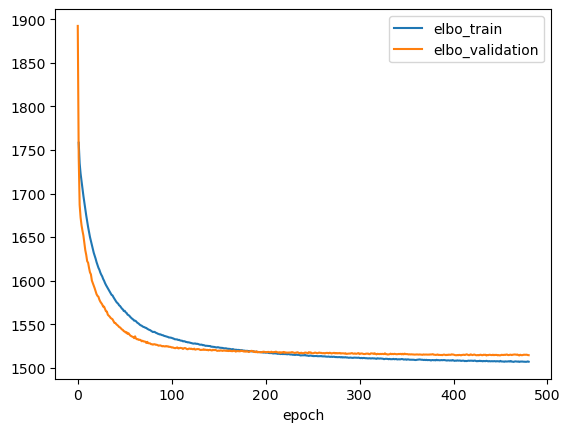

In [8]:
ax = vae.history['elbo_train'][1:].plot()
vae.history['elbo_validation'].plot(ax=ax)
#Y label is the sample error number

In [9]:
data.obs["celltype_scanvi"] = 'Unknown'
ref_idx = data.obs['batch'] == "reference"
data.obs["celltype_scanvi"][ref_idx] = data.obs['cell_type'][ref_idx]

/tmp/ipykernel_2962964/134013430.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs["celltype_scanvi"][ref_idx] = data.obs['cell_type'][ref_idx]


In [10]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=data,
    labels_key="celltype_scanvi",
    unlabeled_category="Unknown",
)


/vol/mbconda/imarais/miniconda3/envs/snapatac2/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/vol/mbconda/imarais/miniconda3/envs/snapatac2/lib/python3.10/site-packages/scvi/data/_utils.py:172: UserWarning: Category 16 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


In [11]:
lvae.train(max_epochs=481, n_samples_per_label=100)

INFO     Training for 481 epochs.                                                                                  


/vol/mbconda/imarais/miniconda3/envs/snapatac2/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.10 /vol/mbconda/imarais/miniconda3/envs/snapatac2/l ...
  rank_zero_warn(
2023-03-31 03:38:08 - INFO - GPU available: False, used: False
2023-03-31 03:38:08 - INFO - TPU available: False, using: 0 TPU cores
2023-03-31 03:38:08 - INFO - IPU available: False, using: 0 IPUs
2023-03-31 03:38:08 - INFO - HPU available: False, using: 0 HPUs
/vol/mbconda/imarais/miniconda3/envs/snapatac2/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.10 /v

Epoch 481/481: 100%|██████████████████████████████████████| 481/481 [47:29<00:00,  6.21s/it, loss=1.62e+03, v_num=1]

2023-03-31 04:25:38 - INFO - `Trainer.fit` stopped: `max_epochs=481` reached.


Epoch 481/481: 100%|██████████████████████████████████████| 481/481 [47:29<00:00,  5.92s/it, loss=1.62e+03, v_num=1]


<Axes: xlabel='epoch'>

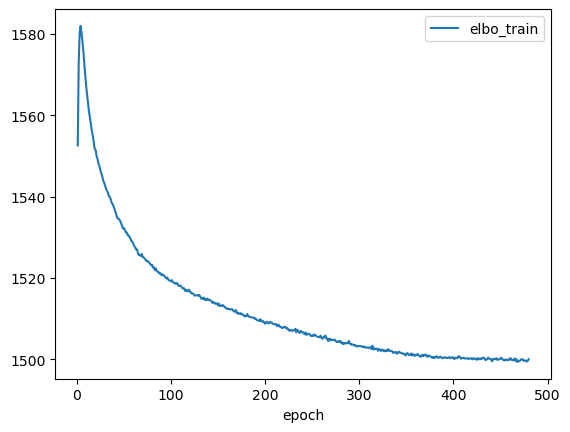

In [12]:
lvae.history['elbo_train'][1:].plot()

In [13]:
data.obs["C_scANVI"] = lvae.predict(data)
data.obsm["X_scANVI"] = lvae.get_latent_representation(data)

In [18]:
del data.obs['is_doublet']

In [19]:
save_file = '/ceph/rimlsfnwi/data/moldevbio/zhou/imarais/jupyter_notebook/data/results/snapatac_concatenate_objects.h5ad'
data.write_h5ad(save_file)

# Save point

In [2]:
#open
data = read_h5ad("/ceph/rimlsfnwi/data/moldevbio/zhou/imarais/jupyter_notebook/data/results/snapatac_concatenate_objects.h5ad")

In [3]:
import scvi

In [41]:
data.obsm

AxisArrays with keys: X_scANVI, X_umap

In [42]:
sc.pp.neighbors(data, use_rep="X_scANVI")
sc.tl.umap(data)

/vol/mbconda/imarais/miniconda3/envs/snapatac2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


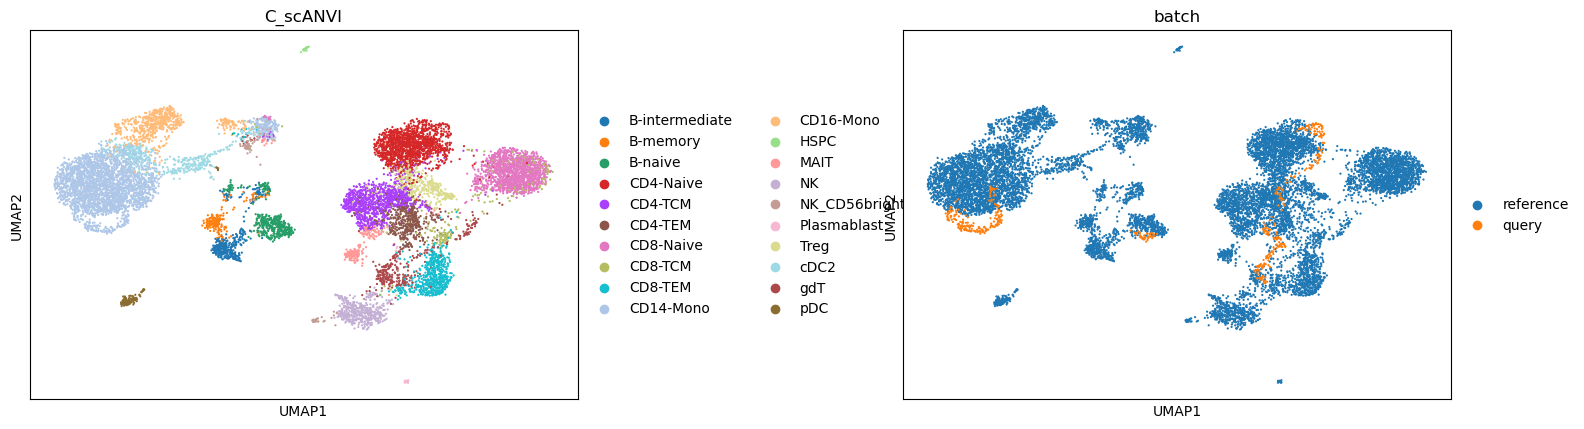

In [35]:
sc.pl.umap(data, color=['C_scANVI', "batch"], wspace=0.45)

In [1]:
#already did
#!pip install pyopenssl

In [4]:
#Load the atac data object from the previous workflow, 
#Which line is specifying data: The second line specifies the observations of data
atac = sc.read('peak_matrix.h5ad') #Loads the atac data  IS IT GENE OR PEAK MATRIX
obs = data.obs #Assigns an 'obs' variable the observations (obs) of our data
obs = obs[obs['batch'] == 'query'] #Only calls upon batch column, for specifically lines labelled 'query' and reassigns obs as only the query ones
obs.index = list(map(lambda x: x.split("-query")[0], obs.index)) #Makes a list after applying the lambda function, its trying to split -query from the number, can you refer to obs.index when it hasnt been specified before
atac.obs['cell_type'] = obs.loc[atac.obs.index]['C_scANVI'] #loc attribute accesses a group of rows and columns by label(s) and is trying to access 'C_scANVI' from atac.obs.index

In [37]:
atac.obs

,tsse,n_fragment,frac_dup,frac_mito,doublet_score,is_doublet,leiden,cell_type
index,,,,,,,,
0,22.386285,33161,0.697916,0.0,0.211679,False,0,CD14-Mono
1,27.009767,23169,0.678588,0.0,0.138298,False,2,gdT
2,33.906634,5234,0.491943,0.0,0.096234,False,0,CD14-Mono
3,21.792392,11853,0.589379,0.0,0.181818,False,0,CD14-Mono
4,30.077486,20552,0.729874,0.0,0.121951,False,2,gdT
...,...,...,...,...,...,...,...,...
453,34.996853,25301,0.725171,0.0,0.121951,False,2,CD8-TEM
454,30.077369,5295,0.628238,0.0,0.121951,False,0,CD14-Mono
455,21.811976,28547,0.690986,0.0,0.250000,False,0,CD14-Mono


In [43]:
atac.obsm

AxisArrays with keys: 

In [8]:
snap.pp.select_features(atac)

In [9]:
snap.tl.spectral(atac)

2023-04-03 11:04:52 - INFO - Compute similarity matrix
2023-04-03 11:04:53 - INFO - Normalization
2023-04-03 11:04:53 - INFO - Perform decomposition


In [10]:
snap.tl.umap(atac, use_dims=17)

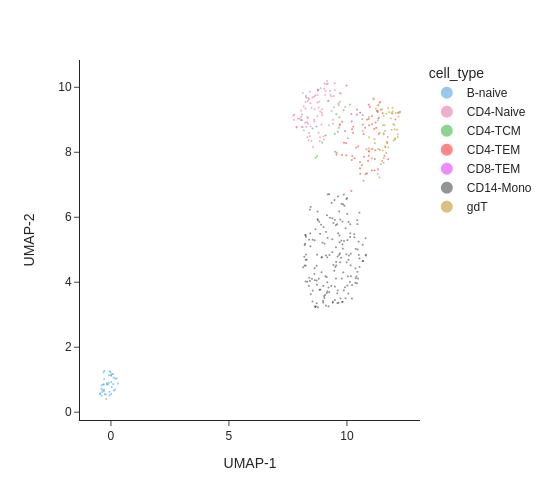

In [11]:
snap.pl.umap(atac, color="cell_type", interactive=False)

/vol/mbconda/imarais/miniconda3/envs/snapatac2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



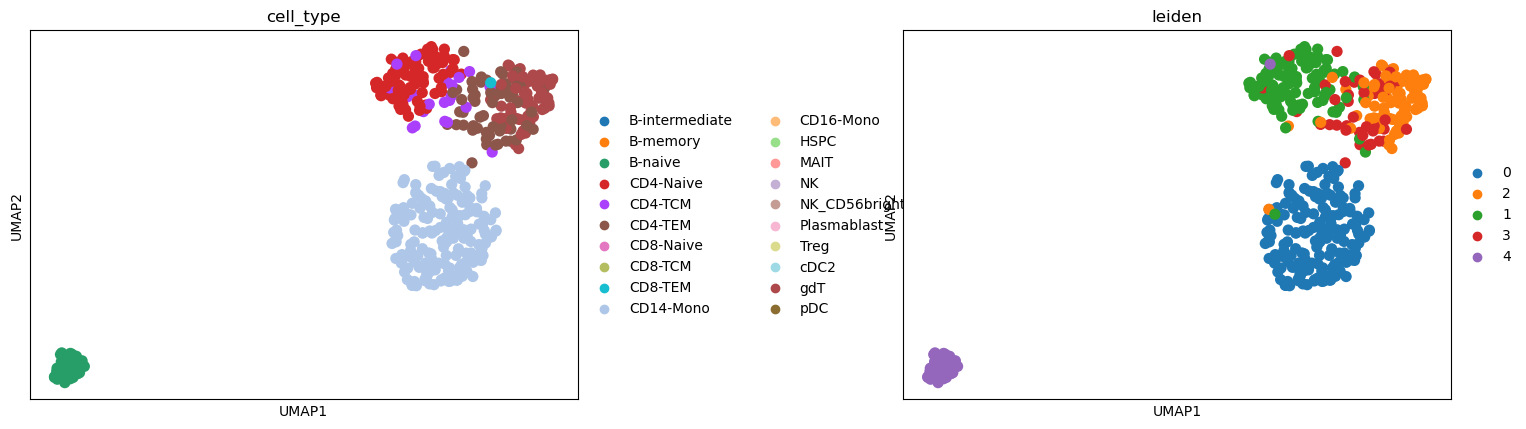

In [12]:
sc.pl.umap(atac, color=['cell_type', "leiden"], wspace=0.45)

In [13]:
save_file = '/ceph/rimlsfnwi/data/moldevbio/zhou/imarais/jupyter_notebook/data/results/atac_sc_rnaseq_predicted_labels.h5ad'
atac.write_h5ad(save_file)

In [14]:
from collections import Counter

cell_type_labels = np.unique(atac.obs['cell_type'])

count_table = {}
for cl, ct in zip(atac.obs['leiden'], atac.obs['cell_type']):
    if cl in count_table:
        count_table[cl].append(ct)
    else:
        count_table[cl] = [ct]

mat = []
for cl, counts in count_table.items():
    c = Counter(counts)
    c = np.array([c[ct] for ct in cell_type_labels])
    c = c / c.sum()
    mat.append(c)

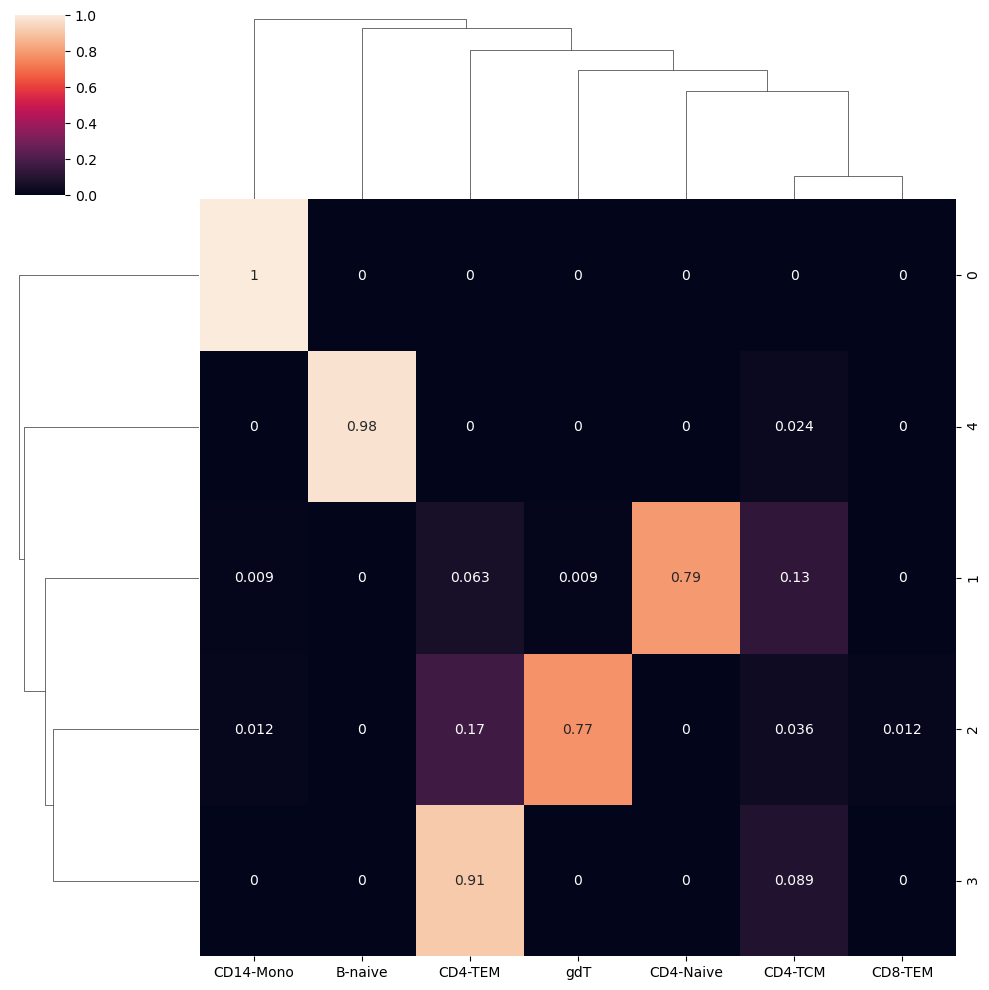

In [15]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(
    mat,
    index = count_table.keys(),
    columns = cell_type_labels,
)
sn.clustermap(df_cm, annot=True)

In [ ]:
annotation = {
    "0": "Naive T",
    "1": "CD14 Mono_1",
    "2": "CD14 Mono_2",
    "3": "CD8 TEM",
    "4": "Memory T",
    "5": "CD16 Mono",
    "6": "MAIT",
    "7": "Memory B",
    "8": "NK",
    "9": "Naive/Intermediate B",
    "10": "DC",
}

atac.obs['cell_type'] = [annotation[i] for i in atac.obs['leiden']]
atac.write("pbmc5k_annotated.h5ad", compression="gzip")